Pareto front size: 148


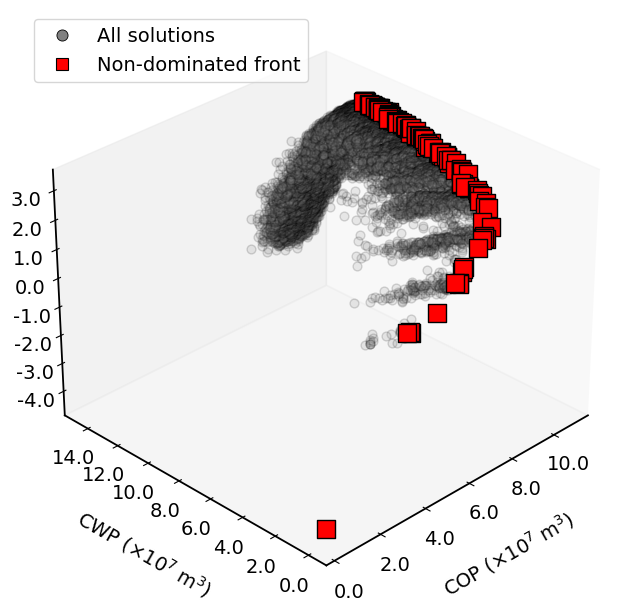

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from matplotlib.lines import Line2D

# ---------------------------------------------------
# Style FIRST (resets rcParams)
# ---------------------------------------------------
plt.style.use("default")

# ---------------------------------------------------
# Global font configuration (AFTER style)
# ---------------------------------------------------
font_size = 14
mpl.rcParams.update({
    "font.size": font_size,
    "axes.labelsize": font_size,
    "axes.titlesize": font_size,
    "xtick.labelsize": font_size,
    "ytick.labelsize": font_size,
    "legend.fontsize": font_size,
    "axes.linewidth": 1.3,
})

# ---------------------------------------------------
# Load dataset
# ---------------------------------------------------
df = pd.read_csv("datasets/MOU2D.csv", delimiter=";", engine="python")

# Use first THREE objectives
objs = df.values[:, -3:].astype(float)

# ---------------------------------------------------
# Objective directions
# True  -> minimize
# False -> maximize
# ---------------------------------------------------
minimize = np.array([False, True, False])

# ---------------------------------------------------
# Dominance check (mixed objectives)
# ---------------------------------------------------
def dominates(q, p, minimize):
    strictly_better = False

    for k in range(len(p)):
        if minimize[k]:
            if q[k] > p[k]:
                return False
            if q[k] < p[k]:
                strictly_better = True
        else:
            if q[k] < p[k]:
                return False
            if q[k] > p[k]:
                strictly_better = True

    return strictly_better

# ---------------------------------------------------
# Update Pareto front with a batch
# ---------------------------------------------------
def update_pareto_front(current_pf, batch, minimize):
    current_pf = list(current_pf)

    for b in batch:
        dominated = False
        to_remove = []

        for i, p in enumerate(current_pf):
            if dominates(p, b, minimize):
                dominated = True
                break
            if dominates(b, p, minimize):
                to_remove.append(i)

        if not dominated:
            for idx in reversed(to_remove):
                current_pf.pop(idx)
            current_pf.append(b)

    return current_pf

# ---------------------------------------------------
# Batch-wise Pareto computation
# ---------------------------------------------------
batch_size = 2000
pareto_frontier = []

for start in range(0, len(objs), batch_size):
    batch = objs[start:start + batch_size]
    pareto_frontier = update_pareto_front(pareto_frontier, batch, minimize)

pf = np.array(pareto_frontier)

print(f"Pareto front size: {len(pf)}")

# ---------------------------------------------------
# Plot (3D)
# ---------------------------------------------------
fig = plt.figure(figsize=(8, 6), constrained_layout=True)
ax = fig.add_subplot(111, projection="3d")

# All solutions
ax.scatter(
    objs[:, 0], objs[:, 1], objs[:, 2],
    color="grey",
    alpha=0.15,
    s=40,
    rasterized=True,
    edgecolors="black",
    depthshade=False,
    zorder=1
)

# Pareto front (ON TOP)
ax.scatter(
    pf[:, 0], pf[:, 1], pf[:, 2],
    color="red",
    s=150,
    marker="s",
    edgecolors="black",
    depthshade=False,
    zorder=100
)

# Axis labels
ax.set_xlabel("COP ($\\times 10^7 \\; \\mathrm{m}^3$)", labelpad=16)
ax.set_ylabel("CWP ($\\times 10^7 \\; \\mathrm{m}^3$)", labelpad=16)
ax.set_zlabel("NPV ($\\times 10^9 \\; \\mathrm{USD}$)", labelpad=16)

# Axis formatting
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x/1e7:.1f}"))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x/1e7:.1f}"))
ax.zaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x/1e9:.1f}"))

ax.grid(False)
ax.tick_params(colors="black", width=1.3)

# Legend
legend_elements = [
    Line2D(
        [0], [0],
        marker="o",
        linestyle="",
        markerfacecolor="grey",
        markeredgecolor="black",
        markeredgewidth=0.6,
        markersize=8,
        label="All solutions"
    ),
    Line2D(
        [0], [0],
        marker="s",
        linestyle="",
        markerfacecolor="red",
        markeredgecolor="black",
        markeredgewidth=0.8,
        markersize=9,
        label="Non-dominated front"
    )
]

ax.legend(
    handles=legend_elements,
    loc="upper left",
    frameon=True
)

# View angle
ax.view_init(elev=30, azim=225)

plt.savefig("figures/MOU2D.pdf", dpi=300)
plt.show()


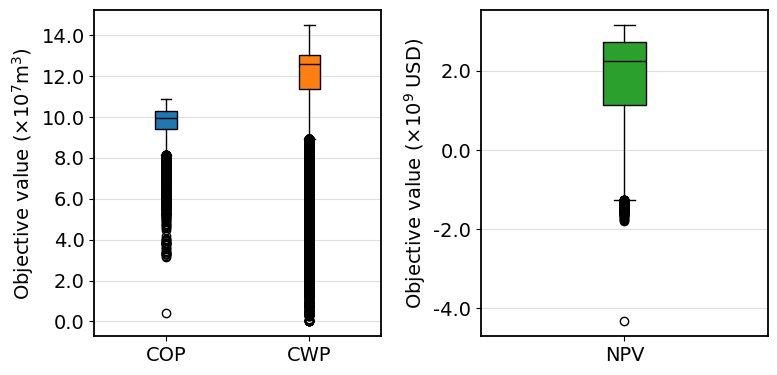

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Extract objective columns
cop = [row[0] for row in objs]
cwp = [row[1] for row in objs]
npv = [row[2] for row in objs]

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=False)

# ---------- COP & CWP ----------
box1 = axes[0].boxplot(
    [cop, cwp],
    tick_labels=["COP", "CWP"],
    showfliers=True,
    patch_artist=True
)

colors = ["tab:blue", "tab:orange"]

for element in ["boxes", "whiskers", "caps", "medians"]:
    plt.setp(box1[element], color="black")

for patch, color in zip(box1["boxes"], colors):
    patch.set_facecolor(color)

axes[0].set_ylabel("Objective value ($\\times 10^7 \\mathrm{m}^3$)")
axes[0].yaxis.set_major_formatter(
    FuncFormatter(lambda y, _: f"{y/1e7:.1f}")
)
axes[0].grid(True, axis="y", alpha=0.4)

# ---------- NPV ----------
box2 = axes[1].boxplot(
    [npv],
    tick_labels=["NPV"],
    showfliers=True,
    patch_artist=True
)

for element in ["boxes", "whiskers", "caps", "medians"]:
    plt.setp(box2[element], color="black")

box2["boxes"][0].set_facecolor("tab:green")

axes[1].set_ylabel("Objective value ($\\times 10^9 \\; \\mathrm{USD}$)")
axes[1].yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f"{x/1e9:.1f}")
)
axes[1].grid(True, axis="y", alpha=0.4)

plt.tight_layout()
plt.savefig("figures/boxplot_MOU2D.pdf")
plt.show()


In [3]:
df.head(10)

,nWWcat,nWPr05,nWPr11,nWPr12,nWPr13,nWPr18,nWPr19,nWPr20,nWPr24,nWPr25,...,nWIn73,nWIn80,nWIn81,nWIn82,nWIn83,nWIn84,nWIn85,COP,CWP,NPV
0,0,0,1,0,0,1,0,1,0,0,...,0,1,1,0,0,1,1,83972900,138679000.0,-3.665009e+08
1,1,1,1,0,1,0,1,1,0,1,...,1,0,1,1,1,1,1,89668800,133318000.0,-1.083977e+09
2,1,1,0,1,0,0,0,0,0,1,...,0,1,1,0,1,1,0,90093600,132164000.0,-1.698340e+08
3,0,1,0,0,1,0,0,0,1,0,...,1,1,1,0,1,0,0,89497800,134126000.0,1.783223e+08
4,1,0,0,1,1,1,0,1,0,1,...,1,0,0,1,1,1,0,88157100,133868000.0,-8.317915e+07
5,1,0,0,0,1,1,0,1,1,0,...,1,1,1,0,1,1,1,85490700,136309000.0,-8.615414e+08
6,0,0,1,1,0,1,1,1,1,0,...,1,1,0,1,1,0,0,90070700,133085000.0,-8.806618e+08
7,0,0,0,1,1,0,1,0,0,1,...,0,0,1,0,1,1,1,86154300,136293000.0,-4.084878e+08
8,0,0,0,0,0,1,1,1,0,1,...,1,1,1,1,1,1,1,90513900,131846000.0,-4.406556e+08
9,0,1,1,0,0,0,1,1,1,0,...,0,1,1,1,1,0,1,88154900,135990000.0,-7.272671e+08


In [4]:
display(df.dtypes)

nWWcat      int64
nWPr05      int64
nWPr11      int64
nWPr12      int64
nWPr13      int64
           ...   
nWIn84      int64
nWIn85      int64
COP         int64
CWP       float64
NPV       float64
Length: 130, dtype: object

In [6]:
# Configurações para exibição completa de DataFrames no pandas

# # Mostrar mais linhas
# pd.set_option('display.max_rows', 150)

# # Mostrar mais colunas
# pd.set_option('display.max_columns', None)

# # Mostrar a largura completa das colunas
# pd.set_option('display.max_colwidth', None)

# Resetar para padrão (se necessário)
# pd.reset_option('display.max_rows')

## Preprocessing

In [5]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
   

preprocessor = Pipeline(steps=[
    ("scaler", StandardScaler())
])

## Regression

In [6]:
#########################
# DATA
#########################

# dado
X = df.drop(columns=["COP",	"CWP", "NPV"]) 
y = df[["COP",	"CWP", "NPV"]]

In [9]:
#########################
# MODELS
#########################

from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import os


algorithms = {

    "RF": (
        RandomForestRegressor(random_state=0),
        {
            "model__n_estimators": [100, 200],
            "model__max_depth": [5, 10, None]
        }
    ),

    "GB": (
        MultiOutputRegressor(GradientBoostingRegressor(random_state=0)),
        {
            "model__estimator__n_estimators": [100, 200],
            "model__estimator__learning_rate": [0.05, 0.1]
        }
    ),

    "SVR": (
        MultiOutputRegressor(SVR()),
        {
            "model__estimator__C": [0.1, 1, 10, 50],
            "model__estimator__kernel": ["linear", "rbf"],
             "model__estimator__gamma": ["scale", "auto"]
        }
    ),

    "Ridge": (
        MultiOutputRegressor(Ridge()),
        {"model__estimator__alpha": [0.1, 1, 10]}
    ),

    "Lasso": (
        MultiOutputRegressor(Lasso(max_iter=5000)),
        {"model__estimator__alpha": [0.01, 0.1, 1]}
    ),

    "ElasticNet": (
        MultiOutputRegressor(ElasticNet(max_iter=5000)),
        {
            "model__estimator__alpha": [0.01, 0.1, 1],
            "model__estimator__l1_ratio": [0.1, 0.5, 0.9]
        }
    ),

    "KNN": (
        MultiOutputRegressor(KNeighborsRegressor()),
        {"model__estimator__n_neighbors": [3, 5, 7]}
    ),

    "CatBoost": (
    MultiOutputRegressor(
        CatBoostRegressor(
            loss_function="RMSE",
            random_seed=42,
            verbose=False,      # <-- SILENCIA LOGS
            thread_count=1      # <-- controle de paralelismo (fair comparison)
        )
    ),
    {
        "model__estimator__iterations": [300, 500],
        "model__estimator__learning_rate": [0.01, 0.05, 0.1],
        "model__estimator__depth": [6, 8, 10],
        "model__estimator__l2_leaf_reg": [1, 3, 5]
    }
),

    "XGBoost": (
    MultiOutputRegressor(
        XGBRegressor(
            objective="reg:squarederror",
            tree_method="hist",     
            device='cuda',       # força uso da GPU
            random_state=42,
            n_jobs=1
        )
    ),
    {
        "model__estimator__n_estimators": [200, 400],
        "model__estimator__max_depth": [3, 5, 7],
        "model__estimator__learning_rate": [0.01, 0.05, 0.1],
        "model__estimator__subsample": [0.8, 1.0],
        "model__estimator__colsample_bytree": [0.8, 1.0]
    }
    ),

    "LightGBM": (
        MultiOutputRegressor(
            LGBMRegressor(
                objective="regression",
                random_state=42,
                n_jobs=1,
                verbosity=-1, # silencia warnings
                device='gpu',       # força uso da GPU
                gpu_platform_id=0,  
                gpu_device_id=0     
            )
        ),
        {
            "model__estimator__n_estimators": [200, 400],
            "model__estimator__learning_rate": [0.01, 0.05, 0.1],
            "model__estimator__max_depth": [-1, 5, 10],
            "model__estimator__num_leaves": [31, 63, 127],
            "model__estimator__subsample": [0.8, 1.0],
            "model__estimator__colsample_bytree": [0.8, 1.0]
        }
    )
}


In [10]:
###########################
# PIPELINE
###########################

import time
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(
    "ignore",
    message=".*Falling back to prediction using DMatrix.*"
)

def run_multioutput_regression_cv(
    algorithms,
    X,
    y,
    preprocessor,
    n_splits=5
):
    scores = {}
    best_params = {}
    times = {}

    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for name, (model, param_grid) in algorithms.items():

        print(f"Treinando {name}...")

        start_alg = time.time()

        fold_scores = []

        pipe = Pipeline(steps=[
            ("preprocess", preprocessor),
            ("model", model)
        ])

        grid = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=param_grid,
            n_iter=10,
            scoring="neg_mean_squared_error",
            cv=cv,
            n_jobs=-1,
            verbose=2,
            random_state=42
        )

        start_search = time.time()
        grid.fit(X, y)
        end_search = time.time()
        search_time = end_search - start_search
        best_params[name] = grid.best_params_

        start_cv = time.time()
        # Avaliação por fold
        for train_idx, test_idx in cv.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            grid.best_estimator_.fit(X_train, y_train)
            y_pred = grid.best_estimator_.predict(X_test)

            fold_scores.append({
                "mse": mean_squared_error(y_test, y_pred, multioutput="uniform_average"),
                "mae": mean_absolute_error(y_test, y_pred, multioutput="uniform_average"),
                "r2": r2_score(y_test, y_pred, multioutput="uniform_average")
            })
        end_cv = time.time()
        cv_time = end_cv - start_cv

        scores[name] = fold_scores

        # ---- SALVA RESULTADOS PARCIAIS ----
        mean_results = pd.DataFrame({
            alg: [
                np.mean([s['mse'] for s in scores[alg]]),
                np.mean([s['mae'] for s in scores[alg]]),
                np.mean([s['r2'] for s in scores[alg]])
            ]
            for alg in scores
        }, index=['MSE', 'MAE', 'R²'])

        std_results = pd.DataFrame({
            alg: [
                np.std([s['mse'] for s in scores[alg]]),
                np.std([s['mae'] for s in scores[alg]]),
                np.std([s['r2'] for s in scores[alg]])
            ]
            for alg in scores
        }, index=['MSE', 'MAE', 'R²'])

        mean_results.to_csv("/home/flopes/artigo_matheus_jan26/2026_bracis_datasets/results/results_MOU2D/regression_results_mean.csv")
        std_results.to_csv("/home/flopes/artigo_matheus_jan26/2026_bracis_datasets/results/results_MOU2D/regression_results_std.csv")
        pd.DataFrame(best_params).T.to_csv("/home/flopes/artigo_matheus_jan26/2026_bracis_datasets/results/results_MOU2D/regression_best_params.csv")

        end_alg = time.time()
        total_time = end_alg - start_alg

        times[name] = {
            "search_time_min": search_time / 60,
            "cv_time_min": cv_time / 60,
            "total_time_min": total_time / 60
        }

    return scores, best_params, times

In [11]:
ini = time.time()
# Rodando a validação cross-validation
scores, best_params, times = run_multioutput_regression_cv(
    algorithms=algorithms,
    X=X,          
    y=y,         
    preprocessor=preprocessor,
    n_splits=5 
)

fim = time.time()
print('\nTempo TOTAL de execução:', round((fim - ini) / 60, 2), 'minutos')

times_df = pd.DataFrame(times).T.round(2)
times_df.to_csv("/home/flopes/artigo_matheus_jan26/2026_bracis_datasets/results/results_MOU2D/regression_times.csv")

print("\nTempo de execução por algoritmo (minutos)")
display(times_df)

mean_results = pd.DataFrame({
    alg: [
        np.mean([s['mse'] for s in scores[alg]]),
        np.mean([s['mae'] for s in scores[alg]]),
        np.mean([s['r2'] for s in scores[alg]])
    ]
    for alg in scores
}, index=['MSE', 'MAE', 'R²'])


std_results = pd.DataFrame({
    alg: [
        np.std([s['mse'] for s in scores[alg]]),
        np.std([s['mae'] for s in scores[alg]]),
        np.std([s['r2'] for s in scores[alg]])
    ]
    for alg in scores
}, index=['MSE', 'MAE', 'R²'])


mean_results.to_csv("/home/flopes/artigo_matheus_jan26/2026_bracis_datasets/results/results_MOU2D/regression_results_mean.csv")
std_results.to_csv("/home/flopes/artigo_matheus_jan26/2026_bracis_datasets/results/results_MOU2D/regression_results_std.csv")

pd.DataFrame(best_params).T.to_csv("/home/flopes/artigo_matheus_jan26/2026_bracis_datasets/results/results_MOU2D/regression_best_params.csv")

print("Média das métricas (↓ MSE/MAE melhor, ↑ R² melhor)")
display(mean_results.round(4))

print("Desvio padrão das métricas")
display(std_results.round(4))

Treinando RF...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ........model__max_depth=5, model__n_estimators=100; total time=  26.2s
[CV] END ........model__max_depth=5, model__n_estimators=100; total time=  26.5s
[CV] END ........model__max_depth=5, model__n_estimators=100; total time=  26.5s
[CV] END ........model__max_depth=5, model__n_estimators=100; total time=  26.7s
[CV] END ........model__max_depth=5, model__n_estimators=100; total time=  26.9s
[CV] END .......model__max_depth=10, model__n_estimators=100; total time=  49.5s
[CV] END .......model__max_depth=10, model__n_estimators=100; total time=  50.1s
[CV] END .......model__max_depth=10, model__n_estimators=100; total time=  50.1s
[CV] END .......model__max_depth=10, model__n_estimators=100; total time=  50.3s
[CV] END .......model__max_depth=10, model__n_estimators=100; total time=  50.4s
[CV] END ........model__max_depth=5, model__n_estimators=200; total time=  53.2s
[CV] END ........model__max_depth=5, model__n_estimators=200; total time=  53.2s
[CV] END ........model__max_

/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END model__estimator__learning_rate=0.05, model__estimator__n_estimators=100; total time=  57.6s
[CV] END model__estimator__learning_rate=0.05, model__estimator__n_estimators=100; total time=  57.7s
[CV] END model__estimator__learning_rate=0.05, model__estimator__n_estimators=100; total time=  58.0s
[CV] END model__estimator__learning_rate=0.05, model__estimator__n_estimators=100; total time=  58.1s
[CV] END model__estimator__learning_rate=0.1, model__estimator__n_estimators=100; total time=  58.0s
[CV] END model__estimator__learning_rate=0.1, model__estimator__n_estimators=100; total time=  58.2s
[CV] END model__estimator__learning_rate=0.1, model__estimator__n_estimators=100; total time=  58.3s
[CV] END model__estimator__learning_rate=0.1, model__estimator__n_estimators=100; total time=  58.5s
[CV] END model__estimator__learning_rate=0.05, model__estimator__n_estimators=100; total time=  58.6s
[CV] END model__estimator__learning_rate=0.1, model__estimator__n_estimators=100; tota

/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ........................model__estimator__alpha=0.1; total time=   0.5s
[CV] END ........................model__estimator__alpha=0.1; total time=   0.5s
[CV] END ..........................model__estimator__alpha=1; total time=   0.5s
[CV] END ..........................model__estimator__alpha=1; total time=   0.5s[CV] END ..........................model__estimator__alpha=1; total time=   0.5s

[CV] END ........................model__estimator__alpha=0.1; total time=   0.5s
[CV] END ..........................model__estimator__alpha=1; total time=   0.5s
[CV] END ..........................model__estimator__alpha=1; total time=   0.5s
[CV] END .........................model__estimator__alpha=10; total time=   0.5s
[CV] END .........................model__estimator__alpha=10; total time=   0.5s
[CV] END ........................model__estimator__alpha=0.1; total time=   0.5s
[CV] END ........................model__estimator__alpha=0.1; total time=   0.5s
[CV] END ...................

/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ........................model__estimator__alpha=0.1; total time=  11.2s
[CV] END ........................model__estimator__alpha=0.1; total time=  11.5s
[CV] END ........................model__estimator__alpha=0.1; total time=  11.8s
[CV] END ........................model__estimator__alpha=0.1; total time=  11.9s
[CV] END .......................model__estimator__alpha=0.01; total time=  13.0s
[CV] END ..........................model__estimator__alpha=1; total time=  16.6s
[CV] END ..........................model__estimator__alpha=1; total time=  16.7s
[CV] END ..........................model__estimator__alpha=1; total time=  17.2s
[CV] END ..........................model__estimator__alpha=1; total time=  17.5s
[CV] END ........................model__estimator__alpha=0.1; total time=  17.6s
[CV] END ..........................model__estimator__alpha=1; total time=  17.6s
[CV] END .......................model__estimator__alpha=0.01; total time=  18.2s
[CV] END ...................

/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END model__estimator__alpha=0.1, model__estimator__l1_ratio=0.1; total time=  30.4s
[CV] END model__estimator__alpha=0.1, model__estimator__l1_ratio=0.1; total time=  30.8s
[CV] END model__estimator__alpha=0.1, model__estimator__l1_ratio=0.1; total time=  31.3s
[CV] END model__estimator__alpha=0.1, model__estimator__l1_ratio=0.1; total time=  31.4s
[CV] END model__estimator__alpha=0.1, model__estimator__l1_ratio=0.1; total time=  32.0s
[CV] END model__estimator__alpha=0.01, model__estimator__l1_ratio=0.9; total time=  36.0s
[CV] END model__estimator__alpha=0.01, model__estimator__l1_ratio=0.9; total time=  36.2s
[CV] END model__estimator__alpha=0.01, model__estimator__l1_ratio=0.5; total time=  37.0s
[CV] END model__estimator__alpha=0.01, model__estimator__l1_ratio=0.9; total time=  37.2s
[CV] END model__estimator__alpha=0.01, model__estimator__l1_ratio=0.9; total time=  37.3s
[CV] END model__estimator__alpha=0.01, model__estimator__l1_ratio=0.9; total time=  37.3s
[CV] END model_

/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ....................model__estimator__n_neighbors=3; total time=  10.7s
[CV] END ....................model__estimator__n_neighbors=3; total time=  10.7s
[CV] END ....................model__estimator__n_neighbors=3; total time=  10.7s
[CV] END ....................model__estimator__n_neighbors=5; total time=  10.8s
[CV] END ....................model__estimator__n_neighbors=5; total time=  11.1s
[CV] END ....................model__estimator__n_neighbors=7; total time=  14.8s
[CV] END ....................model__estimator__n_neighbors=5; total time=  15.1s
[CV] END ....................model__estimator__n_neighbors=5; total time=  15.1s
[CV] END ....................model__estimator__n_neighbors=3; total time=  15.2s
[CV] END ....................model__estimator__n_neighbors=3; total time=  15.2s
[CV] END ....................model__estimator__n_neighbors=7; total time=  15.1s
[CV] END ....................model__estimator__n_neighbors=5; total time=  15.3s
[CV] END ...................

/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END model__estimator__colsample_bytree=0.8, model__estimator__learning_rate=0.01, model__estimator__max_depth=3, model__estimator__n_estimators=200, model__estimator__subsample=0.8; total time=  30.3s
[CV] END model__estimator__colsample_bytree=0.8, model__estimator__learning_rate=0.01, model__estimator__max_depth=3, model__estimator__n_estimators=200, model__estimator__subsample=0.8; total time=  30.8s
[CV] END model__estimator__colsample_bytree=0.8, model__estimator__learning_rate=0.01, model__estimator__max_depth=3, model__estimator__n_estimators=200, model__estimator__subsample=0.8; total time=  30.8s
[CV] END model__estimator__colsample_bytree=0.8, model__estimator__learning_rate=0.01, model__estimator__max_depth=3, model__estimator__n_estimators=200, model__estimator__subsample=0.8; total time=  30.9s
[CV] END model__estimator__colsample_bytree=0.8, model__estimator__learning_rate=0.01, model__estimator__max_depth=3, model__estimator__n_estimators=200, model__estimator__subs

/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid featu

[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.1, model__estimator__max_depth=5, model__estimator__n_estimators=400, model__estimator__num_leaves=63, model__estimator__subsample=1.0; total time= 1.7min


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.1, model__estimator__max_depth=5, model__estimator__n_estimators=400, model__estimator__num_leaves=63, model__estimator__subsample=1.0; total time= 1.7min


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid featu

[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.1, model__estimator__max_depth=5, model__estimator__n_estimators=400, model__estimator__num_leaves=63, model__estimator__subsample=1.0; total time= 1.7min
[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.1, model__estimator__max_depth=5, model__estimator__n_estimators=400, model__estimator__num_leaves=63, model__estimator__subsample=1.0; total time= 1.7min


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.1, model__estimator__max_depth=5, model__estimator__n_estimators=400, model__estimator__num_leaves=63, model__estimator__subsample=1.0; total time= 1.7min


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid featu

[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.01, model__estimator__max_depth=10, model__estimator__n_estimators=400, model__estimator__num_leaves=31, model__estimator__subsample=0.8; total time= 2.2min
[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.01, model__estimator__max_depth=10, model__estimator__n_estimators=400, model__estimator__num_leaves=31, model__estimator__subsample=0.8; total time= 2.2min


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid featu

[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.01, model__estimator__max_depth=10, model__estimator__n_estimators=400, model__estimator__num_leaves=31, model__estimator__subsample=0.8; total time= 2.3min
[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.01, model__estimator__max_depth=10, model__estimator__n_estimators=400, model__estimator__num_leaves=31, model__estimator__subsample=0.8; total time= 2.3min
[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.01, model__estimator__max_depth=10, model__estimator__n_estimators=400, model__estimator__num_leaves=31, model__estimator__subsample=0.8; total time= 2.3min


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid featu

[CV] END model__estimator__colsample_bytree=0.8, model__estimator__learning_rate=0.01, model__estimator__max_depth=5, model__estimator__n_estimators=200, model__estimator__num_leaves=63, model__estimator__subsample=1.0; total time=  57.7s
[CV] END model__estimator__colsample_bytree=0.8, model__estimator__learning_rate=0.01, model__estimator__max_depth=5, model__estimator__n_estimators=200, model__estimator__num_leaves=63, model__estimator__subsample=1.0; total time=  57.6s


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid featu

[CV] END model__estimator__colsample_bytree=0.8, model__estimator__learning_rate=0.01, model__estimator__max_depth=5, model__estimator__n_estimators=200, model__estimator__num_leaves=63, model__estimator__subsample=1.0; total time=  58.4s
[CV] END model__estimator__colsample_bytree=0.8, model__estimator__learning_rate=0.01, model__estimator__max_depth=5, model__estimator__n_estimators=200, model__estimator__num_leaves=63, model__estimator__subsample=1.0; total time=  58.1s
[CV] END model__estimator__colsample_bytree=0.8, model__estimator__learning_rate=0.01, model__estimator__max_depth=5, model__estimator__n_estimators=200, model__estimator__num_leaves=63, model__estimator__subsample=1.0; total time=  58.3s


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.1, model__estimator__max_depth=10, model__estimator__n_estimators=400, model__estimator__num_leaves=63, model__estimator__subsample=1.0; total time= 3.7min


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid featu

[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.1, model__estimator__max_depth=10, model__estimator__n_estimators=400, model__estimator__num_leaves=63, model__estimator__subsample=1.0; total time= 3.8min
[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.1, model__estimator__max_depth=10, model__estimator__n_estimators=400, model__estimator__num_leaves=63, model__estimator__subsample=1.0; total time= 3.8min


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.1, model__estimator__max_depth=10, model__estimator__n_estimators=400, model__estimator__num_leaves=63, model__estimator__subsample=1.0; total time= 3.8min


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.1, model__estimator__max_depth=10, model__estimator__n_estimators=400, model__estimator__num_leaves=63, model__estimator__subsample=1.0; total time= 3.8min


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid featu

[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.05, model__estimator__max_depth=10, model__estimator__n_estimators=400, model__estimator__num_leaves=63, model__estimator__subsample=1.0; total time= 4.0min


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid featu

[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.05, model__estimator__max_depth=10, model__estimator__n_estimators=400, model__estimator__num_leaves=63, model__estimator__subsample=1.0; total time= 4.0min


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.05, model__estimator__max_depth=10, model__estimator__n_estimators=400, model__estimator__num_leaves=63, model__estimator__subsample=1.0; total time= 4.0min
[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.05, model__estimator__max_depth=10, model__estimator__n_estimators=400, model__estimator__num_leaves=63, model__estimator__subsample=1.0; total time= 4.0min


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.05, model__estimator__max_depth=10, model__estimator__n_estimators=400, model__estimator__num_leaves=63, model__estimator__subsample=1.0; total time= 4.0min


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid featu

[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.01, model__estimator__max_depth=-1, model__estimator__n_estimators=200, model__estimator__num_leaves=63, model__estimator__subsample=1.0; total time= 2.3min
[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.01, model__estimator__max_depth=-1, model__estimator__n_estimators=200, model__estimator__num_leaves=63, model__estimator__subsample=1.0; total time= 2.3min


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid featu

[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.01, model__estimator__max_depth=-1, model__estimator__n_estimators=200, model__estimator__num_leaves=63, model__estimator__subsample=1.0; total time= 2.3min
[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.01, model__estimator__max_depth=-1, model__estimator__n_estimators=200, model__estimator__num_leaves=63, model__estimator__subsample=1.0; total time= 2.3min


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.01, model__estimator__max_depth=-1, model__estimator__n_estimators=200, model__estimator__num_leaves=63, model__estimator__subsample=1.0; total time= 2.3min


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.1, model__estimator__max_depth=-1, model__estimator__n_estimators=200, model__estimator__num_leaves=63, model__estimator__subsample=0.8; total time= 2.2min


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.1, model__estimator__max_depth=-1, model__estimator__n_estimators=200, model__estimator__num_leaves=63, model__estimator__subsample=0.8; total time= 2.2min


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.1, model__estimator__max_depth=-1, model__estimator__n_estimators=200, model__estimator__num_leaves=63, model__estimator__subsample=0.8; total time= 2.2min


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid featu

[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.1, model__estimator__max_depth=-1, model__estimator__n_estimators=200, model__estimator__num_leaves=63, model__estimator__subsample=0.8; total time= 2.2min
[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.1, model__estimator__max_depth=-1, model__estimator__n_estimators=200, model__estimator__num_leaves=63, model__estimator__subsample=0.8; total time= 2.2min


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.1, model__estimator__max_depth=10, model__estimator__n_estimators=200, model__estimator__num_leaves=31, model__estimator__subsample=1.0; total time= 1.0min


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid featu

[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.1, model__estimator__max_depth=10, model__estimator__n_estimators=200, model__estimator__num_leaves=31, model__estimator__subsample=1.0; total time= 1.1min


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END model__estimator__colsample_bytree=0.8, model__estimator__learning_rate=0.1, model__estimator__max_depth=-1, model__estimator__n_estimators=200, model__estimator__num_leaves=31, model__estimator__subsample=1.0; total time= 1.3min


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid featu

[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.1, model__estimator__max_depth=10, model__estimator__n_estimators=200, model__estimator__num_leaves=31, model__estimator__subsample=1.0; total time= 1.1min
[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.1, model__estimator__max_depth=10, model__estimator__n_estimators=200, model__estimator__num_leaves=31, model__estimator__subsample=1.0; total time= 1.1min
[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.1, model__estimator__max_depth=10, model__estimator__n_estimators=200, model__estimator__num_leaves=31, model__estimator__subsample=1.0; total time= 1.1min


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END model__estimator__colsample_bytree=0.8, model__estimator__learning_rate=0.1, model__estimator__max_depth=-1, model__estimator__n_estimators=200, model__estimator__num_leaves=31, model__estimator__subsample=1.0; total time= 1.3min


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid featu

[CV] END model__estimator__colsample_bytree=0.8, model__estimator__learning_rate=0.1, model__estimator__max_depth=-1, model__estimator__n_estimators=200, model__estimator__num_leaves=31, model__estimator__subsample=1.0; total time= 1.3min
[CV] END model__estimator__colsample_bytree=0.8, model__estimator__learning_rate=0.1, model__estimator__max_depth=-1, model__estimator__n_estimators=200, model__estimator__num_leaves=31, model__estimator__subsample=1.0; total time= 1.3min
[CV] END model__estimator__colsample_bytree=0.8, model__estimator__learning_rate=0.1, model__estimator__max_depth=-1, model__estimator__n_estimators=200, model__estimator__num_leaves=31, model__estimator__subsample=1.0; total time= 1.3min


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid featu

[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.01, model__estimator__max_depth=10, model__estimator__n_estimators=400, model__estimator__num_leaves=31, model__estimator__subsample=1.0; total time=  53.5s
[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.01, model__estimator__max_depth=10, model__estimator__n_estimators=400, model__estimator__num_leaves=31, model__estimator__subsample=1.0; total time=  53.4s


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid featu

[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.01, model__estimator__max_depth=10, model__estimator__n_estimators=400, model__estimator__num_leaves=31, model__estimator__subsample=1.0; total time=  52.5s
[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.01, model__estimator__max_depth=10, model__estimator__n_estimators=400, model__estimator__num_leaves=31, model__estimator__subsample=1.0; total time=  52.6s
[CV] END model__estimator__colsample_bytree=1.0, model__estimator__learning_rate=0.01, model__estimator__max_depth=10, model__estimator__n_estimators=400, model__estimator__num_leaves=31, model__estimator__subsample=1.0; total time=  52.4s


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid featu


Tempo TOTAL de execução: 209.85 minutos

Tempo de execução por algoritmo (minutos)


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,search_time_min,cv_time_min,total_time_min
RF,4.85,7.52,12.38
GB,2.74,4.46,7.20
SVR,116.61,53.50,170.12
Ridge,0.04,0.01,0.05
Lasso,0.39,0.16,0.55
ElasticNet,1.10,0.22,1.32
KNN,0.27,0.11,0.37
CatBoost,5.44,2.91,8.36
XGBoost,2.57,0.51,3.08
LightGBM,5.67,0.76,6.43


Média das métricas (↓ MSE/MAE melhor, ↑ R² melhor)


,RF,GB,SVR,Ridge,Lasso,ElasticNet,KNN,CatBoost,XGBoost,LightGBM
MSE,1.124840e+16,1.624734e+16,4.513711e+17,2.143564e+16,2.143569e+16,2.143473e+16,1.226854e+16,4.735686e+15,5.480768e+15,5.532368e+15
MAE,3.835872e+07,5.461388e+07,2.872711e+08,6.228322e+07,6.228333e+07,6.228156e+07,4.145372e+07,2.880928e+07,3.056055e+07,3.126816e+07
R²,9.158000e-01,8.016000e-01,1.626000e-01,6.793000e-01,6.793000e-01,6.793000e-01,9.070000e-01,9.443000e-01,9.474000e-01,9.517000e-01


Desvio padrão das métricas


,RF,GB,SVR,Ridge,Lasso,ElasticNet,KNN,CatBoost,XGBoost,LightGBM
MSE,5.205459e+14,8.001136e+14,4.038541e+15,9.226453e+14,9.225853e+14,9.249707e+14,3.612178e+14,2.065981e+14,2.546963e+14,2.231281e+14
MAE,3.944091e+05,6.658096e+05,1.023948e+06,3.877595e+05,3.876321e+05,3.923827e+05,5.113183e+05,1.184318e+05,2.332089e+05,1.413916e+05
R²,7.700000e-03,6.600000e-03,1.240000e-02,7.400000e-03,7.400000e-03,7.500000e-03,2.300000e-03,1.900000e-03,2.200000e-03,2.200000e-03


## MLP Regression (with Keras)

In [7]:
import os

# Aponta para a pasta 'lib' do seu ambiente, onde criamos a pasta 'nvvm'
# O TensorFlow vai automaticamente procurar por 'nvvm/libdevice/libdevice.10.bc' dentro deste caminho
os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=/home/flopes/miniconda3/envs/gpu_env/lib"

# Opcional: Garante que as bibliotecas do CUDA (cudart, cublas) sejam achadas
os.environ['LD_LIBRARY_PATH'] = f"/home/flopes/miniconda3/envs/gpu_env/lib:{os.environ.get('LD_LIBRARY_PATH', '')}"

import tensorflow as tf

2026-01-28 11:52:26.321520: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-28 11:52:26.893253: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-28 11:52:26.942889: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-28 11:52:26.968689: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-28 11:52:27.520580: I tensorflow/core/platform/cpu_feature_guar

In [8]:
import time
import numpy as np
import tensorflow as tf
import keras_tuner as kt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:

def build_mlp(hp, n_features, n_outputs):
    model = Sequential()

    # Número de camadas ocultas
    n_layers = hp.Int("n_layers", min_value=1, max_value=3)

    for i in range(n_layers):
        # Número de unidades na camada
        units = hp.Int(f"units_{i}", min_value=64, max_value=512, step=64)

        # Função de ativação
        activation = hp.Choice(f"activation_{i}", ["relu", "tanh", "swish", "gelu"])

        # Camada densa com L2
        model.add(
            Dense(
                units,
                activation=activation,
                kernel_regularizer=l2(hp.Choice("l2", [0.0, 1e-4, 1e-3])),
                input_shape=(n_features,) if i == 0 else None
            )
        )

        # Batch Normalization opcional
        if hp.Boolean("batch_norm"):
            model.add(BatchNormalization())

        # Dropout
        model.add(Dropout(hp.Float("dropout", min_value=0.0, max_value=0.5, step=0.1)))

    # Camada de saída (regressão multi-output)
    model.add(Dense(n_outputs, activation="linear"))

    # Escolha do otimizador
    optimizer_name = hp.Choice("optimizer", ["adam", "rmsprop"])
    lr = hp.Choice("lr", [1e-2, 5e-3, 1e-3, 5e-4, 1e-4])

    optimizer = Adam(learning_rate=lr) if optimizer_name == "adam" else RMSprop(learning_rate=lr)

    model.compile(optimizer=optimizer, loss="mse")

    return model

In [11]:
def run_mlp_cv_keras_tuner(
    X,
    y,
    preprocessor,
    n_splits=5,
    max_trials=10,
    epochs=100,
    batch_size=32
):

    scores = []
    best_params = {}
    times = {}

    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    start_total = time.time()
    search_time = 0
    cv_time = 0

    for fold, (train_idx, test_idx) in enumerate(cv.split(X), 1):

        print(f"\nMLP – Fold {fold}/{n_splits}")

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Preprocessamento (fit apenas no treino)
        X_train_p = preprocessor.fit_transform(X_train)
        X_test_p  = preprocessor.transform(X_test)

        tuner = kt.RandomSearch(
            lambda hp: build_mlp(
                hp,
                n_features=X_train_p.shape[1],
                n_outputs=y.shape[1]
            ),
            objective="val_loss",
            max_trials=max_trials,
            directory="keras_tuner",
            project_name=f"mlp_fold_{fold}",
            overwrite=True
        )

        start_search = time.time()
        tuner.search(
            X_train_p,
            y_train,
            validation_split=0.2,
            epochs=epochs,
            batch_size=batch_size,
            verbose=0
        )
        search_time += time.time() - start_search

        best_model = tuner.get_best_models(1)[0]
        best_hp = tuner.get_best_hyperparameters(1)[0].values

        start_cv = time.time()
        y_pred = best_model.predict(X_test_p, verbose=0)
        cv_time += time.time() - start_cv

        scores.append({
            "mse": mean_squared_error(y_test, y_pred, multioutput="uniform_average"),
            "mae": mean_absolute_error(y_test, y_pred, multioutput="uniform_average"),
            "r2":  r2_score(y_test, y_pred, multioutput="uniform_average")
        })

        best_params[f"fold_{fold}"] = best_hp

        tf.keras.backend.clear_session()

    total_time = time.time() - start_total

    times = {
        "search_time_min": search_time / 60,
        "cv_time_min": cv_time / 60,
        "total_time_min": total_time / 60
    }

    return scores, best_params, times

In [12]:
scores_mlp, best_params_mlp, times_mlp = run_mlp_cv_keras_tuner(
    X=X,
    y=y,
    preprocessor=preprocessor,
    n_splits=5
)


MLP – Fold 1/5


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-01-28 11:55:17.705343: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14165 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:65:00.0, compute capability: 8.6
I0000 00:00:1769612122.765887 2224043 service.cc:146] XLA service 0x7247600173a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769612122.765967 2224043 service.cc:154]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2026-01-28 11:55:23.216142: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268]


MLP – Fold 2/5


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
 


MLP – Fold 3/5


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
 


MLP – Fold 4/5


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
 


MLP – Fold 5/5


/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-01-28 13:39:22.096844: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_328', 36 bytes spill stores, 40 bytes spill loads

/home/flopes/miniconda3/envs/gpu_env/lib/python3.10/

In [13]:
display(scores_mlp)
display(times_mlp)

[{'mse': 1.7352049268935885e+17,
  'mae': 188575184.0,
  'r2': -23.508378982543945},
 {'mse': 2.100782321106944e+16, 'mae': 53565856.0, 'r2': -0.7427244186401367},
 {'mse': 6.009041327394652e+17,
  'mae': 387646336.0,
  'r2': -0.12238621711730957},
 {'mse': 1.13123801432064e+16, 'mae': 62718676.0, 'r2': -10.31683349609375},
 {'mse': 9391392669302784.0, 'mae': 36713436.0, 'r2': 0.4422871768474579}]

{'search_time_min': 126.82326222658158,
 'cv_time_min': 0.05148095687230428,
 'total_time_min': 127.02939853668212}

In [14]:
scores_2 = {}
best_params_2 = {}
times_2 = {}

scores_2["MLP"] = scores_mlp
best_params_2["MLP"] = best_params_mlp
times_2["MLP"] = times_mlp

times_df = pd.DataFrame(times_2).T.round(2)
times_df.to_csv("/home/flopes/artigo_matheus_jan26/2026_bracis_datasets/results/results_MOU2D/regression_times_MLP.csv")

print("\nTempo de execução por algoritmo (minutos)")
display(times_df)

mean_results_2 = pd.DataFrame({
    alg: [
        np.mean([s['mse'] for s in scores_2[alg]]),
        np.mean([s['mae'] for s in scores_2[alg]]),
        np.mean([s['r2'] for s in scores_2[alg]])
    ]
    for alg in scores_2
}, index=['MSE', 'MAE', 'R²'])

std_results_2 = pd.DataFrame({
    alg: [
        np.std([s['mse'] for s in scores_2[alg]]),
        np.std([s['mae'] for s in scores_2[alg]]),
        np.std([s['r2'] for s in scores_2[alg]])
    ]
    for alg in scores_2
}, index=['MSE', 'MAE', 'R²'])

mean_results_2.to_csv("/home/flopes/artigo_matheus_jan26/2026_bracis_datasets/results/results_MOU2D/regression_results_mean_MLP.csv")
std_results_2.to_csv("/home/flopes/artigo_matheus_jan26/2026_bracis_datasets/results/results_MOU2D/regression_results_std_MLP.csv")
pd.DataFrame(best_params_2).T.to_csv("/home/flopes/artigo_matheus_jan26/2026_bracis_datasets/results/results_MOU2D/regression_best_params_MLP.csv")
pd.DataFrame(best_params_2["MLP"]).T.to_csv("/home/flopes/artigo_matheus_jan26/2026_bracis_datasets/results/results_MOU2D/mlp_best_params_per_fold.csv")

print("Média das métricas (↓ MSE/MAE melhor, ↑ R² melhor)")
display(mean_results_2.round(4))

print("Desvio padrão das métricas")
display(std_results_2.round(4))


Tempo de execução por algoritmo (minutos)


,search_time_min,cv_time_min,total_time_min
MLP,126.82,0.05,127.03


Média das métricas (↓ MSE/MAE melhor, ↑ R² melhor)


,MLP
MSE,1.632272e+17
MAE,1.458439e+08
R²,-6.849600e+00


Desvio padrão das métricas


,MLP
MSE,2.274366e+17
MAE,1.323850e+08
R²,9.222300e+00
